\textbf{How $a$ is obtained from the probability distribution}

Suppose $\Omega = \mathcal{P}(\Omega_1) \times \mathcal{P}(\Omega_2)$

Define $$a^\star: \Omega_i \times \mathcal{P}(\Omega_j) \to [0,\pi/2]$$
$$a^\star(z,x_i) = a^\star(x_i|z) = [-\ln(p_r(x_i|z) - a^\star(x_i|\Omega_j)^{-1}]^{-1},\text{ where j is s.t. }z \not\in \Omega_j $$

Now define $$a: \mathcal{P}(\Omega_i) \times \mathcal{P}(\Omega_j) \to [0,\pi/2]$$
$$a(z,x) = a(x|z) = \sum_{x_i \in x}a^\star(x_i|z)$$

Want to have $$a(\Omega_1|z) = \sum_{x_i \in \Omega_1}a^\star(x_i|z) = \pi/2$$ in order to use bijection $$f: [0,\pi/2] \to \mathbb{R}_+\cup \{\infty\},\ f(\theta) = \tan(\theta)$$

Question: how to make sure $\sum_{x_i \in \Omega_1}a^\star(x_i|z) = \pi/2$? 

Assumption: $a = \overline{a}$

PERHAPS NEED TO RECONSIDER THIS.

In [682]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme  
set_nb_theme('chesterish')

In [70]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import *
import random
import numpy as np
import math

EVENT SPACES AND THE NETWORK ARE GLOBAL VARIABLES. PERHAPS DO A CLASS LATER

In [693]:
epsilon = 10**(-8)

In [335]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    combs = list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
    return set([frozenset(ee) for ee in combs])

In [2]:
def ass(from_ee, to_ee, seed):
    '''
    both arguments are elementary events, subsets of one or two elementary spaces.
    returns the strength of the association: a(to_ee|from_ee)
    '''
    if from_ee==to_ee:
        return 1
    if to_ee == set():
        return epsilon
    if to_ee in list_of_full_ee_spaces:
        return np.inf
    #otherwise return a random value
    np.random.seed(seed)
    return abs(np.random.normal(1,1))

In [688]:
def add_random_weights(G):
    '''G is a complete graph'''
    seed = SEED
    for tuple_of_elem_events in product(list(G.nodes()),repeat = 2):
        G.add_edge(*tuple_of_elem_events, key = 'weight', weight = ass(*tuple_of_elem_events,seed))
        seed += 1

In [403]:
def get_sources_of_uncertainty():
    '''takes in set of events. outputs a list.
    assume omega is not empty'''
    return tuple([i for i in range(len(random.sample(omega, 1)[0]))])

I think $x_i$ does not have to be a proper subset of $z_i$. Rather, $i \in \Gamma(x|z) \iff z_i \not\subset x_i$

In [314]:
def get_relevant_sources_of_uncertainty(event_under_question, known_event, sources_of_uncertainty):
    '''takes in sets. outputs a set'''
    relevant_sources_of_uncertainty = []
    for i in sources_of_uncertainty:
        if event_under_question[i].issubset(known_event[i]) and \
        event_under_question[i] != known_event[i]:      #choose proper subsets
            relevant_sources_of_uncertainty.append(i)
    return tuple(relevant_sources_of_uncertainty)

In [620]:
def get_belief(event_under_question, known_event):
    '''returns agent's belief that event_under_question is true conditional on 
    known_event being true'''
    sources_of_uncertainty = get_sources_of_uncertainty()
    #use p(x|z) = p(x intersect z|z)
    target_event = tuple([x[i].intersection(z[i]) for i in sources_of_uncertainty])
    relevant_sources_of_uncertainty = \
    get_relevant_sources_of_uncertainty(target_event, known_event, sources_of_uncertainty)
    #print(relevant_sources_of_uncertainty)
    result = 0
    for k in sources_of_uncertainty:
        for i in relevant_sources_of_uncertainty:
            for j in relevant_sources_of_uncertainty:
                a_bar = G[target_event[j]][target_event[i]]["weight"]["weight"] #from target_event[j] to target_event[i]
                a = G[known_event[k]][target_event[j]]["weight"]["weight"] #from known_event[k] to target_event[j]
                #print("Edge from {} to {} is {:.2f}".format(str(target_event[j]),str(target_event[i]),a_bar))
                #print("Edge from {} to {} is {:.2f}".format(str(known_event[k]),str(target_event[j]),a))
                #print(result)
                result += 1 / ( a_bar * a )
    return math.exp((-1)*result)

In [664]:
omega_1 = {"lib", "sp"}
omega_2 = {"int+", "int", "ext", "ext+"}
list_of_full_ee_spaces = [omega_1, omega_2]
pow_omega_1 = set(powerset(omega_1))
pow_omega_2 = set(powerset(omega_2))
omega = set(product(pow_omega_1, pow_omega_2))

In [697]:
G = nx.MultiDiGraph()
G.add_nodes_from(pow_omega_1, )
G.add_nodes_from(pow_omega_2)
SEED = 421
add_random_weights(G)

In [698]:
random.seed(SEED)
x = random.sample(omega, 1)[0]
z = random.sample(omega, 1)[0]
prior = (frozenset(omega_1),frozenset(omega_2))
belief = get_belief(x,z)
prior_belief = get_belief(x,prior)
print("p(x|z) = p({}|{}) =\n{:.10f}".format(x, z, belief))
print("p(x|prior) = p_p({}|{}) =\n{:.10f}".format(x, prior, prior_belief))
print("Posterior/Prior = {:.6f}".format(belief/prior_belief))

p(x|z) = p((frozenset({'lib'}), frozenset({'ext+'}))|(frozenset({'lib'}), frozenset({'ext', 'ext+', 'int'}))) =
0.0455769718
p(x|prior) = p_p((frozenset({'lib'}), frozenset({'ext+'}))|(frozenset({'sp', 'lib'}), frozenset({'ext', 'int+', 'int', 'ext+'}))) =
0.0000000028
Posterior/Prior = 16483836.008376


p(x|z) = p((frozenset({'lib'}), frozenset({'ext', 'int'}))|(frozenset({'lib', 'sp'}), frozenset({'int+', 'int', 'ext+'}))) = 0.0000000018


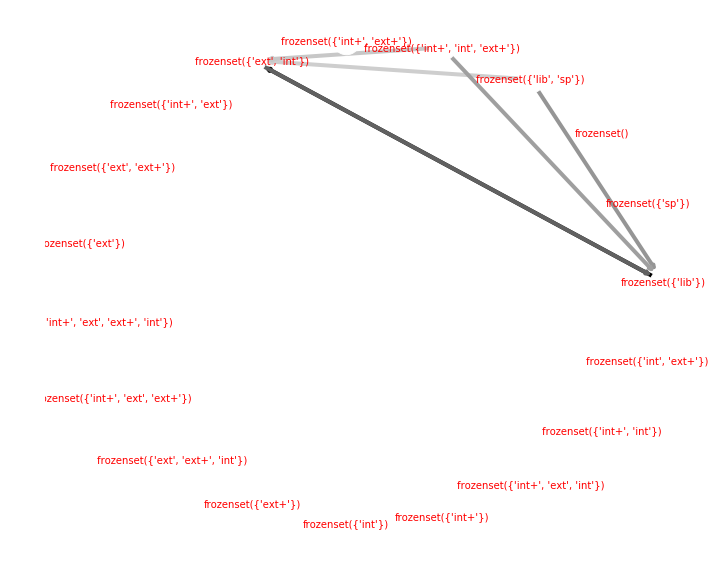

In [551]:
edgelist = []
colors = []
for (from_node, to_node, wt) in G.edges.data('weight'):
    if (from_node in x and to_node in x) or \
    (from_node in z and to_node in x):
        edgelist.append((from_node, to_node, wt))
        colors.append(wt)

#################  PLOTTING  #######################
plt.figure(num=2, figsize=(12, 10))
plt.axis('off')
print("p(x|z) = p({}|{}) = {:.10f}".format(x, z, belief))
nx.draw_networkx(G, pos = nx.shell_layout(G), node_size = 700, node_color = 'w', width = 4, with_labels = True, \
                 font_color = 'r', font_size = 10, edgelist = edgelist, arrowsize = 6, \
                 edge_cmap = plt.cm.get_cmap('Greys'), edge_color = colors, edge_vmin = 0, edge_vmax = max(colors))
plt.show()
####################################################